# Traits models initial run

A first pass fitting a few different sklearn classifiers to the T2D and Lipids datasets. Though some initial preprocessing is conducted on the data no feature selection is performed at this stage. It should be noted that this notebook is meant to show an exploratory look into out of the box model performance. It should be noted that as there are currently more features than samples in the datasets (2750 features vs ~2100 samples), there aren't enough degrees of freedom to optimally fit an interpretable linear model.

In [5]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
import warnings
from matplotlib import pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')
import sklearn 
import jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from Evaluator import Evaluator
import itertools

### Data Preprocessing

In [1]:
# Alter with lipids/t2d/other if needed
train_filepath = "../data/lipids_data/lipids_training_ML_table.txt"
test_filepath = "../data/lipids_data/lipids_testing_ML_table.txt"

# Used to name the output files
out_train = "../data/lipids_data/lipids_train.csv"
out_test = "../data/lipids_data/lipids_test.csv"

In [2]:
train_df = pd.read_table(train_filepath)
test_df = pd.read_table(test_filepath)
train_df.tail()

NameError: name 'pd' is not defined

In [3]:
# Read in data and compare class balances
def show_counts(df, pos_col, neg_col):
    positives = df['type'].value_counts()[pos_col]
    controls = df['type'].value_counts()[neg_col]
    total = len(df)
    print ("Total samples: {} \nPositives: {} \nControls: {}".format(total, positives, controls))

In [4]:
# Read in training data and compare class balances
show_counts(train_df, 'index', 'control')

NameError: name 'train_df' is not defined

In [74]:
# Read in testing data and compare class balances
show_counts(test_df, 'index', 'control')

Total samples: 1057 
Positives: 151 
Controls: 906


In [75]:
# Change labels to 0 or 1 for control or positive
train_df['type'] = train_df['type'].apply(lambda x: 0 if x == 'control' else 1)
test_df['type'] = test_df['type'].apply(lambda x: 0 if x == 'control' else 1)

# Add sample weights based on prevalence of class
train_df['weight'] = train_df['type'].apply(lambda x: 1.5 if x == 1 else 1)

In [76]:
train_df.head()

,snp,type,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,...,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount,weight
0,Chr14_Group_208,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,3,1.5
1,Chr1_Group_824,1,1,0,0,1,0,1,0,1,...,0,0,0,0,0,1,1,1,418,1.5
2,Chr19_Group_468,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,26,1.5
3,Chr1_Group_214154719,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,22,1.5
4,Chr14_Group_282,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1.5


In [77]:
# Drop the snp feature so that only numerical data remains
train_df = train_df.drop(['snp'], axis=1)
test_df = test_df.drop(['snp'], axis=1)

In [78]:
# Verify value counts are the same to check conversion was performed correctly
show_counts(train_df, 1, 0)

Total samples: 2100 
Positives: 300 
Controls: 1800


In [79]:
show_counts(test_df, 1, 0)

Total samples: 1057 
Positives: 151 
Controls: 906


In [80]:
# Write out data to file so we don't have to repeat preprocessing 
# every time we train a model from a different file
train_df.to_csv(out_train)
test_df.to_csv(out_test)

In [81]:
# Shuffle dataframe
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [82]:
# Create training and test sets for model
X_train = train_df.drop(['type', 'weight'], axis=1)
y_train = train_df.loc[:, 'type']

X_test = test_df.drop(['type'], axis=1)
y_test = test_df.loc[:, 'type']

In [83]:
# If we want to add sample weights
sample_weight = train_df['weight']

In [84]:
# Init class for model evaluation - detailed in Evaluation.py
ev = Evaluator()

### Logistic Regression 

Sklearn's logistic regression model, with ten fold cross validation. Using the following parameters:
* cv = 10
* penalty = L1 (Same as lasso regression)
* class_weight = balanced (Sets regularization term C to 1/(class frequency) for each sample. Useful for imbalanced datasets. 

In [85]:
log_model = LogisticRegressionCV(solver='liblinear', 
                                 penalty='l1', 
                                 class_weight='balanced',
                                 scoring='roc_auc', 
                                 cv=10,
                                 max_iter=5000)
log_model.fit(X_train, y_train, sample_weight=sample_weight)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5000,
           multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring='roc_auc',
           solver='liblinear', tol=0.0001, verbose=0)

In [86]:
print("Training Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_train, y_train, threshold=0.5)

Training Dataset Logistic Model Performance:
 Precision: 0.2921589688506982
 Recall: 0.9066666666666666
 Accuracy: 0.6728571428571428


In [87]:
print("Test Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_test, y_test, threshold=0.5)

Test Dataset Logistic Model Performance:
 Precision: 0.21822033898305085
 Recall: 0.6821192052980133
 Accuracy: 0.6054872280037843


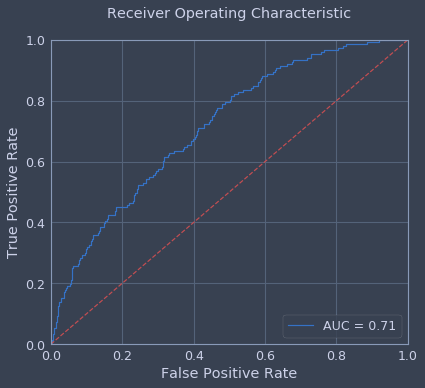

In [88]:
ev.plot_roc_curve(log_model, X_test, y_test)

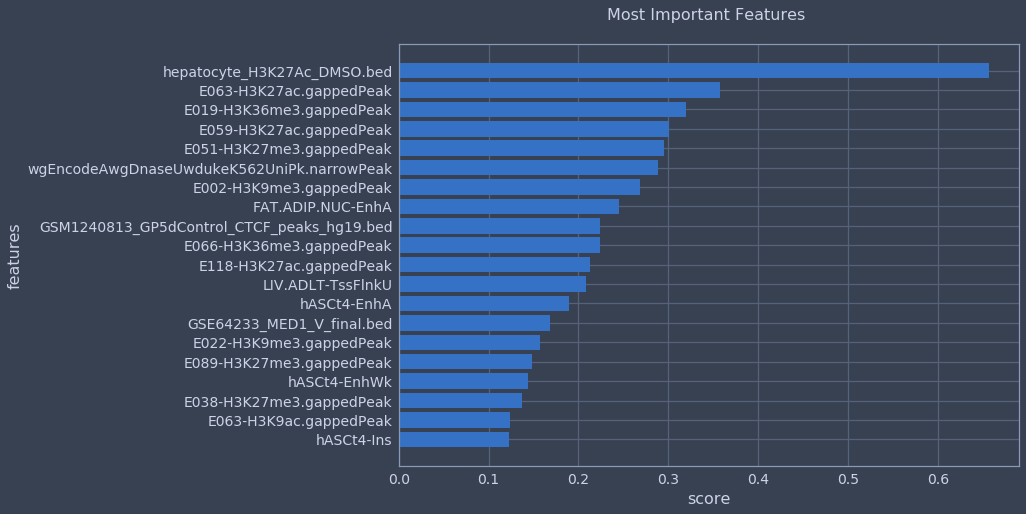

In [89]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, False)

# Random Forest

In [90]:
# n_jobs = -1 allows training to be done on all available cores
rf_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced')

# Parameter grid for grid search
rf_params = {'n_estimators': [100, 500, 1000, 2000],
			 'max_depth': [30, 100, 200]}

scoring = ['recall', 'roc_auc']

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3)

In [91]:
# Grid search to iteratively search parameter space
rf_grid = GridSearchCV(rf_model, param_grid=rf_params, cv=cv, scoring=scoring, refit='recall')
rf_grid.fit(X_train, y_train, sample_weight=sample_weight)
print("The best parameters are %s with a score of %0.2f" % (rf_grid.best_params_, rf_grid.best_score_))

rf_grid_score = rf_grid.score(X_test, y_test)
print ("Grid search's score on new test data was {}".format(rf_grid_score))

The best parameters are {'max_depth': 30, 'n_estimators': 100} with a score of 0.02
Grid search's score on new test data was 0.013245033112582781


In [92]:
ev.summarize_performance(rf_grid, X_train, y_train, proba=False)

Model Performance:
 Precision: 1.0
 Recall: 1.0
 Accuracy: 1.0


In [93]:
ev.summarize_performance(rf_grid.best_estimator_, X_test, y_test, proba=False)

Model Performance:
 Precision: 0.6666666666666666
 Recall: 0.013245033112582781
 Accuracy: 0.8580889309366131


In [94]:
top_n_features = 20

forest = rf_grid.best_estimator_
importances = rf_grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(top_n_features):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[f], importances[indices[f]]))

Feature ranking:
1. feature MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed (0.007138)
2. feature MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed (0.005295)
3. feature GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed (0.005133)
4. feature K562_ChIP-seq_CTCF_ENCFF002CEL.bed (0.005022)
5. feature K562_ChIP-seq_POLR2A_ENCFF002CET.bed (0.004168)
6. feature endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed (0.003649)
7. feature endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed (0.003533)
8. feature keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed (0.003459)
9. feature keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed (0.003150)
10. feature H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed (0.003134)
11. feature mammary_epithelial_cell_ChIP-seq_CTCF_ENCFF002CEB.bed (0.003121)
12. feature HepG2_ChIP-seq_CTCF_ENCFF002CDZ.bed (0.002791)
13. feature H1-hESC_ChIP-seq_CTCF_ENCFF002CDS.bed (0.002746)
14. feature H1-hESC_ChIP-seq_H3K4me3_ENCFF001SVC.bed 

### Support Vector Machine 

When used with a linear kernel still allows for evaluation of feature coefficients. Class weight parameter sets regularization parameter C for class i to n_samples / (n_classes * np.bincount(y)) 

In [95]:
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, max_iter=5000)
svm_model.fit(X_train, y_train, sample_weight=sample_weight)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=5000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [96]:
print("Training Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_train, y_train, proba=False)

Training Dataset SVM Model Performance:
 Precision: 1.0
 Recall: 0.9966666666666667
 Accuracy: 0.9995238095238095


In [97]:
print("Training Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_test, y_test, proba=False)

Training Dataset SVM Model Performance:
 Precision: 0.2713178294573643
 Recall: 0.23178807947019867
 Accuracy: 0.8013245033112583


In [98]:
# Display samples that have been chosen as support vectors
svec_indices = svm_model.support_
svec_df = X_train.iloc[[124, 60, 112, 184, 53], :]
svec_df.tail()

,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed,H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed,...,Hepatocyte_PPARA_GW7647_2hr.bed,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
1213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,18
1653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,14
1167,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8


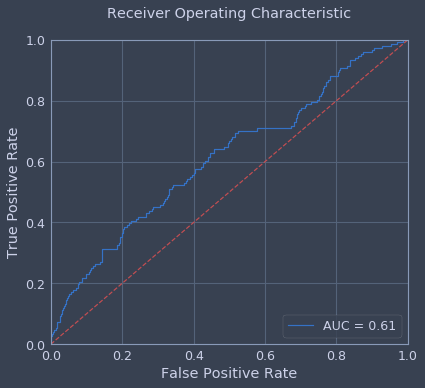

In [99]:
ev.plot_roc_curve(svm_model, X_test, y_test)

In [1]:
# Plot feature importance
coefs = svm_model.coef_
feature_names = X_train.columns
ev.feat_importance(coefs, feature_names, 20)

### Complement Naive Bayes

Designed to combat the assumptions made by the standard multinomial naive bayes classifier. Particularly suited for imbalanced datasets as the priors are calculated by using the complement of the class of each sample. 

In [ ]:
cnb_model = ComplementNB()
cnb_model.fit(X_train, y_train, sample_weight=None)

In [ ]:
print("Training Dataset CNB", end=" ")
ev.summarize_performance(cnb_model, X_train, y_train, proba=False)

In [ ]:
print("Training Dataset CNB", end=" ")
ev.summarize_performance(cnb_model, X_test, y_test, proba=False)

In [ ]:
ev.plot_roc_curve(cnb_model, X_test, y_test)